<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/pytorch-mnist-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Import necessary libraries to create a variational autoencoder
The code is mainly developed using the PyTorch library
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
"""
Determine if any GPUs are available 
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [4]:
"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 70691723.46it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86587343.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24268158.93it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17688513.25it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5) 
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [6]:
"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [7]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}: Loss {}'.format(epoch, loss))
        

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 12256.3359375
Epoch 1: Loss 10986.283203125
Epoch 2: Loss 10915.537109375
Epoch 3: Loss 10687.529296875
Epoch 4: Loss 10275.15234375
Epoch 5: Loss 9949.4951171875
Epoch 6: Loss 9972.990234375
Epoch 7: Loss 9955.0498046875
Epoch 8: Loss 10428.9140625
Epoch 9: Loss 9842.19921875


In [11]:
!ls

data  PML_2023	sample_data


In [12]:
torch.save(net, 'PML_2023/ConvNet.pt')

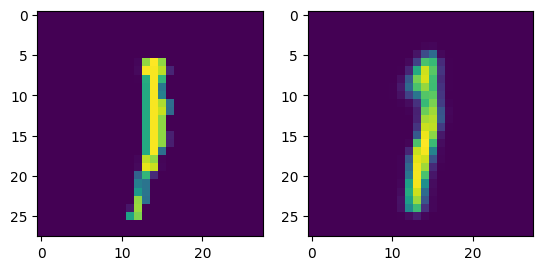

In [13]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

## Load generic VAE for comparison

In [15]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 91534519.97it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114386868.58it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24253180.37it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14699482.07it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Hyper-parameters
image_size = 784
#h_dim = 400
#z_dim = 20
num_epochs = 50
x_dim=784, 
h_dim1= 512, 
h_dim2=256, 
z_dim=2
learning_rate = 1e-3

In [25]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
#vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=2)
vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [26]:
vae.parameters

<bound method Module.parameters of VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)>

In [27]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [28]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [29]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
              data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [30]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.091016
Train Epoch: 1 [10000/60000 (17%)]	Loss: 190.893789
Train Epoch: 1 [20000/60000 (33%)]	Loss: 167.428906
Train Epoch: 1 [30000/60000 (50%)]	Loss: 171.218184
Train Epoch: 1 [40000/60000 (67%)]	Loss: 168.723809
Train Epoch: 1 [50000/60000 (83%)]	Loss: 161.871689
====> Epoch: 1 Average loss: 178.7854
====> Test set loss: 161.0679
Train Epoch: 2 [0/60000 (0%)]	Loss: 165.337559
Train Epoch: 2 [10000/60000 (17%)]	Loss: 153.766494
Train Epoch: 2 [20000/60000 (33%)]	Loss: 154.633457
Train Epoch: 2 [30000/60000 (50%)]	Loss: 164.140332
Train Epoch: 2 [40000/60000 (67%)]	Loss: 159.095811
Train Epoch: 2 [50000/60000 (83%)]	Loss: 152.961992
====> Epoch: 2 Average loss: 157.8183
====> Test set loss: 154.8225
Train Epoch: 3 [0/60000 (0%)]	Loss: 153.219238
Train Epoch: 3 [10000/60000 (17%)]	Loss: 154.658447
Train Epoch: 3 [20000/60000 (33%)]	Loss: 156.197070
Train Epoch: 3 [30000/60000 (50%)]	Loss: 145.482910
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.15

In [32]:
# store ground truth test images
test_images_ground_truth, _ = next(iter(test_loader))

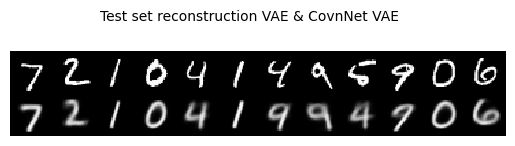

torch.Size([24, 1, 28, 28])


In [39]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set reconstruction VAE & CovnNet VAE', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    #x,_ = next(iter(test_loader))
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)
    print(x_concat.size())

plot_reconstruction(vae)

Ground truth images reformatted are of dimension torch.Size([12, 1, 28, 28])
Concatenated object containing both ground truth & generic VAE is of size torch.Size([12, 784])
Concatenated object also containing ConvNet VAE is of size torch.Size([36, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.FloatTensor


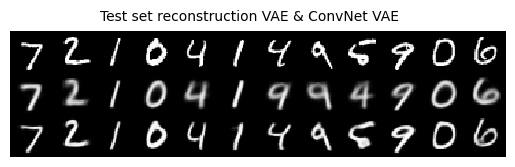

torch.Size([36, 1, 28, 28])


In [62]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set reconstruction VAE & ConvNet VAE', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    print("Ground truth images reformatted are of dimension", x.size())
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object containing both ground truth & generic VAE is of size", out.size())
    ##
    out, mu, logVAR = net(x)
    
    
    x_concat = torch.cat([x_concat, out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object also containing ConvNet VAE is of size", x_concat.size())

    print(out.size())
    print(out.type())
    ##
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)
    print(x_concat.size())

plot_reconstruction(vae)

In [46]:
x = test_images_ground_truth
print(x.size())


#out, _, _ = net(x.view(-1, image_size))

torch.Size([100, 1, 28, 28])


prev


In [54]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        print(imgs.type())
        print(imgs.size())


        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        #plt.subplot(121)
        #plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        print(out.__class__)
        print(out.size())
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        print(outimg.__class__)

        #plt.subplot(122)
        #plt.imshow(np.squeeze(outimg))

torch.FloatTensor
torch.Size([100, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
<class 'numpy.ndarray'>


In [34]:
2+2

4